In [1]:
# AI2 THOR
# !pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,depth2world
from ithor_tools.map2 import single_scenemap
from ithor_tools.landmark_utils import gather,vis_panorama,Word_Dict,choose_ladmark
import random
import math
# from IPython.display import display
# from moviepy.editor import ImageSequenceClip,VideoFileClip

# Co occurance module
from co_occurance.comet_co import co_occurance_score
from co_occurance.move import co_occurance_based_schedular

# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
gridSize=0.05
scene_name = "FloorPlan_Val1_3"
controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=1.5,
    scene = scene_name,
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderClassImage = True,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

INFO - 2022-06-07 14:53:13,424 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [3]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderClassImage = True,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

In [4]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)


In [5]:
import open3d as o3d
def to_rad(th):
    return th*math.pi / 180


In [32]:
class memory():
    def __init__(self,scenebound, reachable_state, landmark_names, 
                                stepsize=0.25, margin=0, vis_loi = False):
        scenebound = np.asarray(scenebound)
        x_max, z_max = np.max(scenebound,axis=0)
        x_min, z_min  = np.min(scenebound,axis=0)
        print(x_min,x_max,z_min,z_max)
        self.stepsize = stepsize
        x_max = self.stepsize* (x_max//self.stepsize)
        z_max = self.stepsize* (z_max//self.stepsize)
        x_min = self.stepsize* (x_min//self.stepsize +1)
        z_min = self.stepsize* (z_min//self.stepsize +1)

        x_len =  x_max- x_min
        z_len =  z_max- z_min
        # print(x_min,x_max,z_min,z_max)
        self.x_min, self.x_max = x_min, x_max
        self.z_min, self.z_max = z_min, z_max
        self.y_default = reachable_state[0]['y']
        w_quan = int(x_len//self.stepsize)+1
        h_quan = int(z_len//self.stepsize)+1
        self.max_obj_size = 20
        self.vis_length = 1.5/stepsize

        self.vis_loi = vis_loi
        self.w_quan = w_quan
        self.h_quan = h_quan
        
        self.grid_map = np.zeros((w_quan,h_quan,3))

        self.landmark_names = landmark_names

        self.landmark_colors = plt.cm.get_cmap('Set3', len(landmark_names))
        self.get_gridmap(reachable_state,margin)
        
        self.get_rstate(reachable_state)

        width = 800
        height = 800
        fov = 90
        self.width = width
        self.height = height
        # camera intrinsics
        focal_length = 0.5 * width / math.tan(to_rad(fov/2))
        fx, fy, cx, cy = (focal_length,focal_length, width/2, height/2)
        self.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, 
                                fx, fy, cx, cy)
        
    def get_gridmap(self,reachable_state,margin):
        rstate = [[r['x'],r['z']] for r in reachable_state]
        rstate = np.asarray(rstate) # [N x 2]
        rstate[:,0] -= self.x_min
        rstate[:,1] -= self.z_min
        rstate /= self.stepsize
        rstate = rstate.astype('int32')
        for r in rstate:
            self.grid_map[r[0],r[1],:] =[1,1,1]
        
    def plot_landmarks(self,controller,show=False):
        self.landmark_loi = []
        self.landmark_loi_name = []
        self.show = show
        for l in self.landmarks:
            pos = self.xyz2grid(l['cp'])
            color = self.landmark_names.index(l['name'])
            lois = self.get_landmark_viewpoint(l['cp'],l['ID'],controller) # World cordinates
            self.landmark_loi.append(lois)
            self.landmark_loi_name.extend([l['name']] *len(lois))
            print(lois)
            for loi in lois:
                loi_grid= self.xyz2grid(loi[0])
                if self.vis_loi:
                    self.grid_map[loi_grid[0],loi_grid[1],:] = self.landmark_colors(color)[:3]

            self.grid_map[pos[0],pos[1],:] = self.landmark_colors(color)[:3]
            
    def visited(self,controller):
        cpos = controller.last_event.metadata['agent']['position']
        cgrid = self.xyz2grid(cpos)
        for i in np.arange(start=-1,stop=1.01,step=0.01):
            self.ray_x(cgrid,i) 
            self.ray_y(cgrid,i) 


    def detect_gt_box(self,controller):
        agent_pos = controller.last_event.metadata['agent']['position']
        agent_rot  = controller.last_event.metadata['agent']['rotation']['y']
        obj_colors = controller.last_event.object_id_to_color
        color_candidate = []
        for lname in self.landmark_names:
            if lname in obj_colors:
                color_candidate.append(dict(color = obj_colors[lname],name = lname))
        print(color_candidate)
        res,vpos = self.get_projection(controller,agent_pos,agent_rot,color_candidate)
        COLOR = controller.last_event.class_segmentation_frame
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(COLOR)
        plt.subplot(1,2,2)
        plt.imshow(res)
        plt.show()
        # res = []
        # for class_name in detection:
        #     if class_name in self.landmark_names:
        #         res.append({'box': detection[class_name],'class':class_name})
        #         color_index = self.landmark_names.index(class_name)


    def get_projection(self,controller,agent_pos,rot,color_candidate):
        DEPTH = controller.last_event.depth_frame
        COLOR = controller.last_event.class_segmentation_frame
      
        # GRAY = np.mean(COLOR,axis=-1)/255
        # GRAY = GRAY.astype(np.float32)

        depth = o3d.geometry.Image(DEPTH)
        color = o3d.geometry.Image(COLOR)
        rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth,
                                                                    depth_scale=1.0,
                                                                    depth_trunc=1.5,
                                                                    convert_rgb_to_intensity=False)
        pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, self.intrinsic)
        pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
        
        rot = math.pi*rot/180
        pcd.transform([[-math.sin(rot), 0,-math.cos(rot), agent_pos['z']],
                [0, 1, 0, agent_pos['y']],
                [math.cos(rot), 0, -math.sin(rot), agent_pos['x']],
                [0, 0, 0, 1]])

        
        voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                                    voxel_size=0.1)
        
        voxels = voxel_grid.get_voxels()  # returns list of voxels
        indices = np.stack(list(vx.grid_index for vx in voxels))
        shape = indices.max(axis=0)
        res = np.zeros((shape[2]+1,shape[0]+1,3))
        vpos= []
        for vx in voxels:
            grid_index = vx.grid_index
            pos_temp = voxel_grid.get_voxel_center_coordinate(grid_index)
            color = vx.color
            temp = res[grid_index[2],grid_index[0]]
            res[grid_index[2],grid_index[0]] = color
            vpos.append(dict(pos=pos_temp,color = color))
        del pcd, voxel_grid
        return res,vpos
    def ray_x(self,start_pos,angle): # -1~1
        x_ = np.arange(start_pos[0]+1,start_pos[0]+1.5/self.stepsize).astype(np.int16)
        y_ = ((angle*(x_-start_pos[0]))+start_pos[1]).astype(np.int16)
        # if sum(temp_map[x_[0],y_[0]+sign[0]:y_[0]+sign[1],0]==0)==0:
        for x,y in zip(x_,y_) or sum(self.grid_map[x+1:x+2,y,0]==0)>0:
            if self.grid_map[x,y,0]==0:
                break
            else:
                self.grid_map[x,y] = [0.5,0.5,0.5]
                
        x_ = np.arange(start_pos[0]-1,start_pos[0]-1.5/self.stepsize,-1).astype(np.int16)
        y_ = ((angle*(x_-start_pos[0]))+start_pos[1]).astype(np.int16)
        if  sum(self.grid_map[x_[0],y_[0]+1:y_[0]+2,0]==1)==0:
            for x,y in zip(x_,y_) or sum(self.grid_map[x-1:x,y,0]==0)>0:
                if self.grid_map[x,y,0]==0:
                    break
                else:
                    self.grid_map[x,y] = [0.5,0.5,0.5]

    def ray_y(self,start_pos,angle): # -1~1
        y_ = np.arange(start_pos[1]+1,start_pos[1]+1.5/self.stepsize).astype(np.int16)
        x_ = ((angle*(y_-start_pos[1]))+start_pos[0]).astype(np.int16)
        if  sum(self.grid_map[x_[0]+1:x_[0]+2,y_[0],0]==0)==0:
            for x,y in zip(x_,y_):
                if self.grid_map[x,y,0]==0 or sum(self.grid_map[x,y-1:y,0]==0)>0: #(temp_map[x,y-1,0]==0 and sum(temp_map[x-1:x+3,y,0]))>1:
                    break
                else:
                    self.grid_map[x,y] = [0.5,0.5,0.5]
        y_ = np.arange(start_pos[1]-1,start_pos[1]-1.5/self.stepsize,-1).astype(np.int16)
        x_ = ((angle*(y_-start_pos[1]))+start_pos[0]).astype(np.int16)
        for x,y in zip(x_,y_):
            if self.grid_map[x,y,0]==0 or sum(self.grid_map[x,y+1:y+2,0]==0)>0:
                break
            else:
                self.grid_map[x,y] = [0.5,0.5,0.5]


    def plot(self, current_pos, query_object = None):
        cpos = self.xyz2grid(current_pos)
        imshow_grid = copy.deepcopy(self.grid_map)
        imshow_grid[cpos[0],cpos[1],:] = [1,0,0]
        if query_object is not None:
            query_pos = self.xyz2grid(query_object)
            imshow_grid[query_pos[0],query_pos[1],:] = [0,0,1]
        imshow_grid = np.rot90(imshow_grid)
        return imshow_grid

    def xyz2grid(self,pos):
        x = pos['x']
        z = pos['z']
        w = int((x - self.x_min)//self.stepsize)
        h = int((z - self.z_min)//self.stepsize)
        return [w,h]

    def grid2xyz(self,gridmap,y=None):
        if y==None:
            y=self.y_default
        x = gridmap[0] * self.stepsize + self.x_min 

        z = gridmap[1] * self.stepsize + self.z_min 
        
        return dict(x=x,y=y,z=z)
    
    def setgoalxyz(self,goal):
        self.goal = self.xyz2grid(goal)
    
    def setstartxyz(self,start):
        self.start = self.xyz2grid(start)
        
    def get_rstate(self,reachable_state):
        rstate = []
        for state in reachable_state:
            w,h = self.xyz2grid(state)
            rstate.append([w,h])
            
        self.rstate = rstate

In [33]:
from ithor_tools.landmark_utils import landmark_names
m = memory(scene_bounds,rstate,landmark_names=landmark_names, stepsize=0.1)

0.6868000030517578 10.52444076538086 -5.351839542388916 0.5981607437133789


[{'color': (209, 156, 101), 'name': 'Bed'}, {'color': (83, 33, 33), 'name': 'DiningTable'}, {'color': (155, 30, 210), 'name': 'Drawer'}, {'color': (39, 54, 158), 'name': 'Shelf'}, {'color': (27, 245, 217), 'name': 'Television'}, {'color': (82, 143, 39), 'name': 'Sofa'}, {'color': (202, 45, 114), 'name': 'SideTable'}, {'color': (18, 14, 75), 'name': 'CoffeeTable'}, {'color': (96, 52, 68), 'name': 'ArmChair'}]


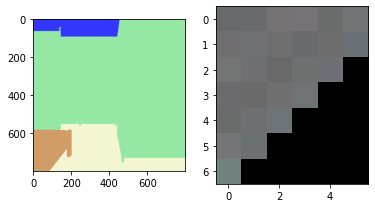

In [34]:
m.detect_gt_box(controller)

(418, 764, 4)


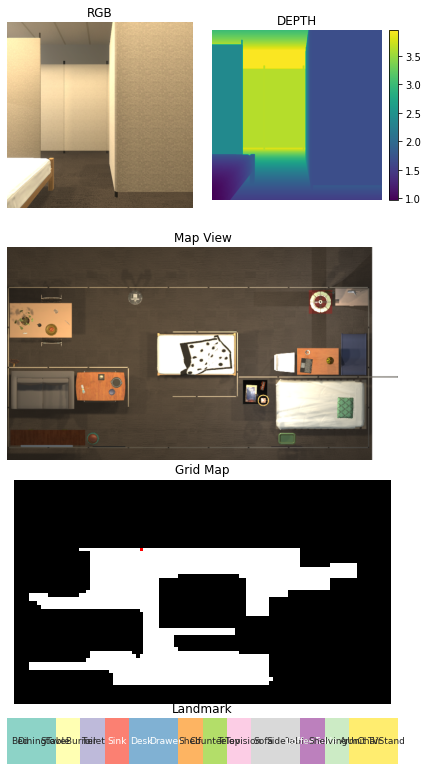

In [44]:
imshow_grid = m.plot(controller.last_event.metadata['agent']['position'])
landmark_config = dict(name=landmark_names,color = m.landmark_colors)
plot_frames(controller.last_event,imshow_grid,landmark_config)

In [22]:
m.visited(controller)

(418, 764, 4)


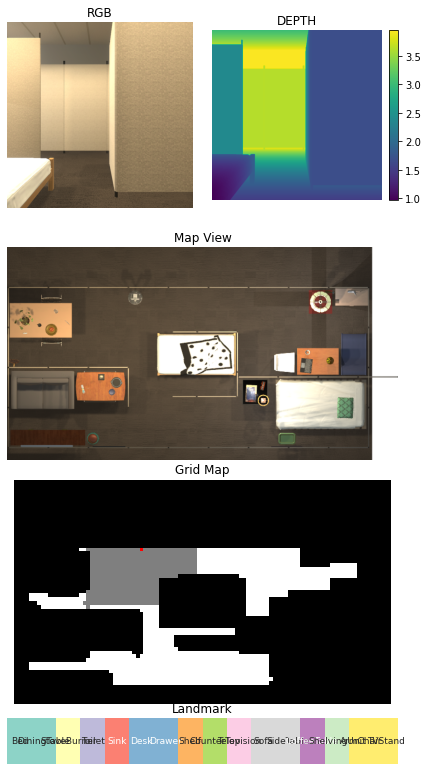

In [23]:
imshow_grid = m.plot(controller.last_event.metadata['agent']['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)

(418, 764, 4)


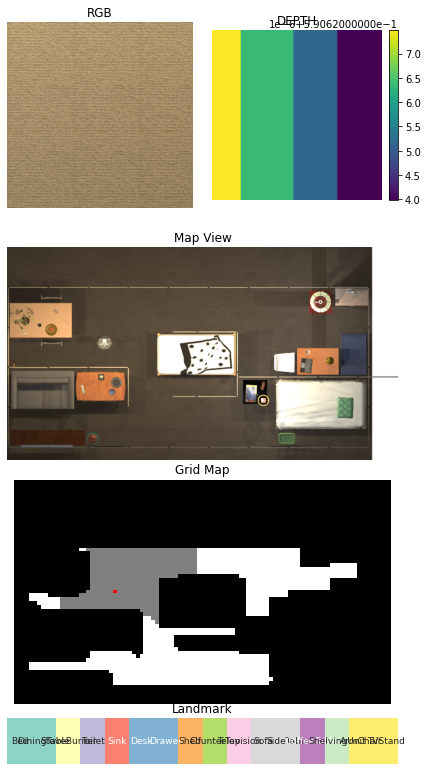

In [24]:
controller.step(
    action="Teleport",
    position = rstate[1000]
)
m.visited(controller)
imshow_grid = m.plot(controller.last_event.metadata['agent']['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)

In [63]:
controller.stop_unity()